In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy
from scipy.integrate import odeint
import math as m
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error


In [2]:
#We choose to convert the .csv file to .xls format and use pandas to parse it:
data = pd.ExcelFile("COVID19_Data_Spain.xls")
sheetX = data.parse(0) 
date = sheetX['Date']
infected = sheetX['Infected']
deaths = sheetX['Deaths']
recovered = sheetX['Recovered']
dt = np.linspace(1,len(infected),len(infected))
a = (1/2.3)
ro = (1/5.2)

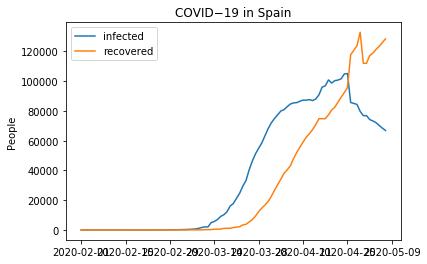

In [3]:
#Plotting real data:
plt.figure(1)
plt.plot(date,infected,label='infected')
plt.plot(date,recovered,label='recovered')
plt.title('COVID−19 in Spain')
plt.ylabel('People')
plt.legend(loc = 'best')
plt.show()

#### Scenario 1: estimating infection rate (r)
Sweep approach to find r and S0

In [4]:
def SIR(I_cond,dt,r,a):
    S0,I0,R0 = I_cond
    dsdt = -r*S0*I0
    didt = r*S0*I0 - a*I0
    drdt = a*I0
    return dsdt,didt,drdt

In [5]:
#Caso SIR model sweep:
Ns = np.linspace(10.3**6,10.6**6,50)
Rs = np.linspace(0.545e-6,0.45e-6,50)

mse = []
for n in Ns:
    mse_n = []
    for r in Rs:
        I_cond = np.array([n,infected[0],recovered[0]])
        model_SIR = odeint(SIR,I_cond,dt,args = (r,a))
        mse_r=mean_squared_error(infected, model_SIR[:,1])
        #mse_r = np.sum((model_SIR[:,1]-infected)**2)/len(infected)
        mse_n.append(mse_r)
    for m in mse_n:
        mse.append(m)

best_fit = min(mse)
index = mse.index(best_fit)
Ns_index = int(index/50)
Rs_index = int(index/50)
print('Best fit: number of population'+' '+str(Ns[Ns_index])+', '+'value of r:'+' '+str(Rs[Rs_index]))

Best fit: number of population 1358966.691757, value of r: 4.7520408163265304e-07


Curve fitting approach to find r and S0

In [6]:
#Caso SIR model fitting
def SIR2(I_cond,dt,r):
    S0,I0,R0 = I_cond
    dsdt = -r*S0*I0
    didt = r*S0*I0 - (1/2.3)*I0
    drdt = (1/2.3)*I0
    return dsdt,didt,drdt

def evolution_SIR(t,r,S0):
    return odeint(SIR2,[S0,1,0],t,args = (r,))[:,1]

In [7]:
params_SIR,params_covariance_SIR = curve_fit(evolution_SIR,dt,infected,[0.45e-6,1.4e6]) #Pillo los del sweep
r_value_SIR = params_SIR[0]
S0_value_SIR = params_SIR[1]
print('The value for r is equal to (SIR):',r_value_SIR)
print('The value for the initial susceptible population is (SIR):',S0_value_SIR)

The value for r is equal to (SIR): 2.2811369474341536e-07
The value for the initial susceptible population is (SIR): 2671886.500571174


#### Scenario 1: predicting when R0 becomes <1 and when the epidemic ends

In [8]:
#R0<1 and the end of the epidemic:
fit_SIR = evolution_SIR(dt,r_value_SIR,S0_value_SIR)
maximum = max(fit_SIR)
tmax = np.where(fit_SIR==maximum)
print('R_0<1: '+str(tmax[0][0])+' days.')

dt_extended = np.linspace(1,300,300)
fit_SIR_extended = evolution_SIR(dt_extended,r_value_SIR,S0_value_SIR)

fin_SIR = 0
cont = 0
for individual in fit_SIR_extended:
    if individual < 1:
        fin_SIR = cont + 2 #0-indexing
        break 
    else: 
        cont = cont+1
print('No more people will get infected after '+str(fin_SIR)+' days of epidemic.')

R_0<1: 76 days.
No more people will get infected after 172 days of epidemic.


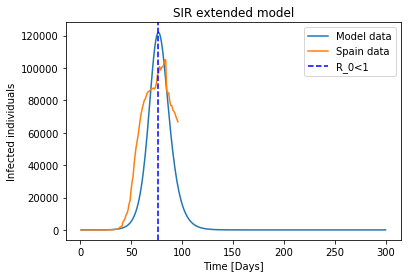

In [9]:
#Representación del resutlado:
plt.figure(1)
plt.plot(dt_extended,fit_SIR_extended,label='Model data')
plt.plot(dt,infected,label='Spain data')
plt.axvline(76,color='blue',linestyle= 'dashed',label='R_0<1')

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()

#### Scenario 2: estimating the quarantine factor, q

In [10]:
#We consider the starting date of the confinment the day 43
day_conf=43
dt_pre_conf=np.linspace(1,day_conf,day_conf)
infected_pre_conf=list(infected[0:day_conf])

#r_value_SIR_pre = r_value_SIR 
#S0_value_SIR_pre = S0_value_SIR 
#print('The value for r before confinment is equal to (SIR):',r_value_SIR)
#print('The value for the initial susceptible population before confinment is (SIR):',S0_value_SIR)

results_pre = odeint(SIR2,[S0_value_SIR ,1,0],dt_pre_conf,args = (r_value_SIR,))
S, I, R = results_pre.T
S_new=S[-1]
I_new=I[-1]
R_new=R[-1]
print('The intial conditions for the confinment are S0 = ',S[-1],', I0 = ',I[-1],', R0 = ',R[-1])

The intial conditions for the confinment are S0 =  2666550.373873703 , I0 =  1526.7933921706126 , R0 =  3810.333305299144


In [11]:
#Caso SIR model fitting durante la cuarentena
def SIR_conf(I_cond,dt,r,q):
    S0,I0,R0 = I_cond
    dsdt = -r*S0*I0
    didt = r*S0*I0 - (1/2.3)*I0-q*I0
    drdt = (1/2.3)*I0+q*I0
    return dsdt,didt,drdt

def evolution_SIR_conf(t,q):
    return odeint(SIR_conf,[S_new,I_new,R_new],t,args = (r_value_SIR,q))[:,1]

Encontrar rango de q con sweep

In [12]:
dt_conf = np.linspace(1,len(infected)-day_conf,len(infected)-day_conf)
infected_conf = infected[day_conf:]
q_sweep = np.linspace(1e-2,1e-1,50)


mse_c = []
for q in q_sweep:
    model_SIR_conf = odeint(SIR_conf,[S_new,I_new,R_new],dt_conf,args = (r_value_SIR,q))
    S, I, R = model_SIR_conf.T
    #mse_r = np.sum((I-infected_conf)**2)/len(infected_conf)
    mse_r=mean_squared_error(infected_conf, I)
    mse_c.append(mse_r)
        
best_fit = min(mse_c)
index = mse_c.index(best_fit)
q_sweep_index = int(index/50)
#print(mse_c)
print('Best fit: number of q'+' '+str(q_sweep[q_sweep_index]))

Best fit: number of q 0.01


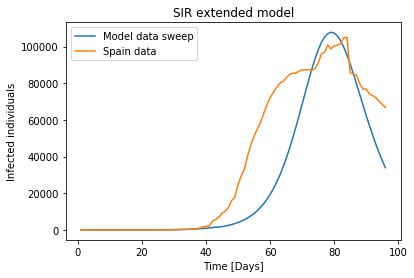

In [13]:
#Representación del resutlado:
q=q_sweep[q_sweep_index]


sweep_SIR_conf=odeint(SIR_conf,[S_new,I_new,R_new],dt[day_conf:],args = (r_value_SIR,q))
#sweep_SIR_conf=odeint(SIR2,[S_new,I_new,R_new],dt[day_conf:],args = (r_value_SIR,))
S_sweep_conf, I_sweep_conf, R_sweep_conf = sweep_SIR_conf.T

I_conf=list(fit_SIR_extended[0:day_conf])
I_conf.extend(I_sweep_conf)

plt.figure(1)
plt.plot(dt,I_conf,label='Model data sweep')
plt.plot(dt,infected,label='Spain data')
#plt.axvline(66,color='blue',linestyle= 'dashed',label='R_0<1')

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()
#print(I_conf)

Encontrar q con curve_fit

In [14]:
params_SIR_conf,params_covariance_SIR_conf = curve_fit(evolution_SIR_conf,dt[day_conf:],infected_conf,1e-2) 
q_value_SIR_conf = params_SIR_conf

print('The value for q is equal to:',q_value_SIR_conf[0])

The value for q is equal to: 0.002627970480552251


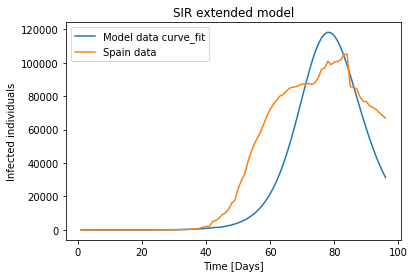

In [15]:
#Representación del resutlado:
q_value=q_value_SIR_conf


sweep_SIR_conf=odeint(SIR_conf,[S_new,I_new,R_new],dt[day_conf:],args = (r_value_SIR,q_value))
#sweep_SIR_conf=odeint(SIR2,[S_new,I_new,R_new],dt[day_conf:],args = (r_value_SIR,))
S_sweep_conf, I_sweep_conf, R_sweep_conf = sweep_SIR_conf.T

I_conf=list(fit_SIR_extended[0:day_conf])
I_conf.extend(I_sweep_conf)

plt.figure(1)
plt.plot(dt,I_conf,label='Model data curve_fit')
plt.plot(dt,infected,label='Spain data')
#plt.axvline(66,color='blue',linestyle= 'dashed',label='R_0<1')

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()
#print(I_conf)

#### Scenario 2: studying the effect of the starting date of confinment

Nota: en aquest primer cas faig variar la date entre el dia 1 i el 50, però mantinc la q que s'havia estimat a l'apartat anterior assumint que la date del confinament era el dia 43.

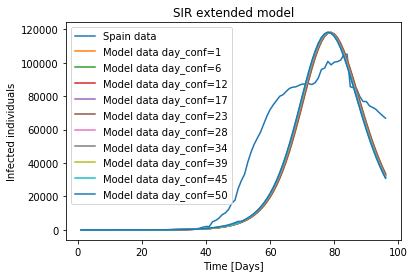

,Day of confinment,I_max,When R0 becomes <1
0,1,118216.0,[78]
1,6,118198.0,[78]
2,12,118165.0,[78]
3,17,118129.0,[78]
4,23,118075.0,[78]
5,28,118088.0,[77]
6,34,118144.0,[77]
7,39,118185.0,[77]
8,45,118237.0,[77]
9,50,118299.0,[77]


In [17]:
#day_conf=[43,44,45,46,47,48,49] #studying 7 days

day_conf=list(np.linspace(1,50,10))
day_conf=[int(round(d)) for d in day_conf]

plt.figure(1)
plt.plot(dt,infected,label='Spain data')
I_max_bis=[]
day_max_bis=[]
for d in day_conf:
    dt_pre_conf=np.linspace(1,d,d)
    infected_pre_conf=list(infected[0:d])
    #before
    results_pre = odeint(SIR2,[S0_value_SIR ,1,0],dt_pre_conf,args = (r_value_SIR,))
    S, I, R = results_pre.T
    S_new=S[-1]
    I_new=I[-1]
    R_new=R[-1]
    #after
    SIR_results_conf=odeint(SIR_conf,[S_new,I_new,R_new],dt[d:],args = (r_value_SIR,q_value))
    S_conf, I_conf, R_conf = SIR_results_conf.T
    I_conf_total=list(fit_SIR_extended[0:d])
    I_conf_total.extend(I_conf)
    I_max_bis.append(round(max(I_conf_total)))
    day_max_bis.append(np.where(I_conf_total==max(I_conf_total))[0])  
    #plot
    plt.plot(dt,I_conf_total,label='Model data day_conf={}'.format(d))

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()
plt.show()
data = {'Day of confinment': day_conf, 'I_max': I_max_bis, "When R0 becomes <1": day_max_bis }
df = pd.DataFrame(data=data)
df

Solo hay una diferencia de 83 infectados, pero además vemos que el número de infectados no crece linealmente ni exponencialmente. Fijate en el valor para el dia 6 y para el dia 12, el pico de infectados para el primero es mayor que para el segundo... no tiene mucho sentido.

Nota: en aquest segon cas faig variar la date entre el dia 1 i el 50, però també faig variar la q. La calculo ajustant els valors experimentals d'Espanya amb un curve fit... potser no seria del tot correcte ja que la date de confinament d'aquests valors experimentals és el dia 43. 

C:\Users\Celia\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """
C:\Users\Celia\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  
C:\Users\Celia\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Celia\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


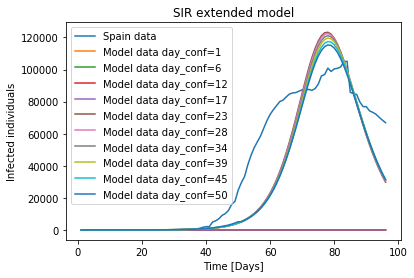

,Day of confinment,q,I_max,When R0 becomes <1
0,1,0.738118,1.0,"[0, 1]"
1,6,0.846844,2.0,"[5, 6]"
2,12,1.377652,7.0,"[11, 12]"
3,17,1.600927,16.0,"[16, 17]"
4,23,-0.000814,123236.0,[77]
5,28,-0.000244,122433.0,[77]
6,34,0.000672,121094.0,[77]
7,39,0.001663,119630.0,[77]
8,45,0.003171,117438.0,[77]
9,50,0.004709,115317.0,[77]


In [16]:
#day_conf=[43,44,45,46,47,48,49] #studying 7 days
day_conf=list(np.linspace(1,50,10))
day_conf=[int(round(d)) for d in day_conf]

plt.figure(1)
plt.plot(dt,infected,label='Spain data')
q_list=[]
I_max=[]
day_max=[]
for d in day_conf:
    dt_pre_conf=np.linspace(1,d,d)
    infected_pre_conf=list(infected[0:d])
    #before
    results_pre = odeint(SIR2,[S0_value_SIR ,1,0],dt_pre_conf,args = (r_value_SIR,))
    S, I, R = results_pre.T
    S_new=S[-1]
    I_new=I[-1]
    R_new=R[-1]
    #after
    infected_conf = infected[d:]
    params_SIR_conf,params_covariance_SIR_conf = curve_fit(evolution_SIR_conf,dt[d:],infected_conf,1) 
    q = params_SIR_conf
    q_list.append(float(q))
    SIR_results_conf=odeint(SIR_conf,[S_new,I_new,R_new],dt[d:],args = (r_value_SIR,q))
    S_conf, I_conf, R_conf = SIR_results_conf.T
    #I_conf_total=list(fit_SIR_extended[0:d])
    I_conf_total=list(I)
    I_conf_total.extend(I_conf)
    I_max.append(round(max(I_conf_total)))
    day_max.append(np.where(I_conf_total==max(I_conf_total))[0])  
    
    #plot
    plt.plot(dt,I_conf_total,label='Model data day_conf={}'.format(d))

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()
data = {'Day of confinment': day_conf, 'q': q_list,'I_max': I_max, "When R0 becomes <1": day_max}
df = pd.DataFrame(data=data)
df

#### Scenario 2: studying the effect of the confinment level (q).

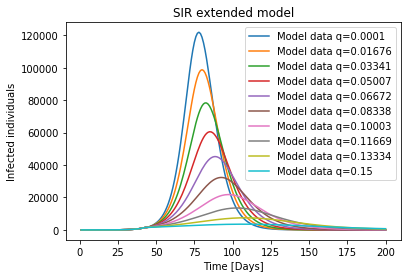

,q,I_max,When R0 becomes <1
0,0.000100,121934.0,[77]
1,0.016756,98819.0,[79]
2,0.033411,78334.0,[81]
3,0.050067,60552.0,[84]
4,0.066722,45228.0,[88]
5,0.083378,32343.0,[92]
6,0.100033,21803.0,[96]
7,0.116689,13534.0,[102]
8,0.133344,7468.0,[107]
9,0.150000,3542.0,[106]


In [33]:
#we set the date of confinment to 43
d=43
#we sweep the value of q
q_sweep=np.linspace(1e-4,1.5e-1,10)
#time before
dt_pre_conf=np.linspace(1,d,d)
#total time
dt_extended=np.linspace(1,200,200)


#before
results_pre = odeint(SIR2,[S0_value_SIR ,1,0],dt_pre_conf,args = (r_value_SIR,))
S, I, R = results_pre.T
S_new=S[-1]
I_new=I[-1]
R_new=R[-1]

#after
I_max=[]
day_max=[]
for q in q_sweep:
    SIR_results_conf=odeint(SIR_conf,[S_new,I_new,R_new],dt_extended[d:],args = (r_value_SIR,q))
    S_conf, I_conf, R_conf = SIR_results_conf.T
    #I_conf_total=list(fit_SIR_extended[0:43])
    I_conf_total=list(I)
    I_conf_total.extend(I_conf)
    I_max.append(round(max(I_conf_total)))
    day_max.append(np.where(I_conf_total==max(I_conf_total))[0])  
    
    #plot
    plt.plot(dt_extended,I_conf_total,label='Model data q={}'.format(round(q,5)))

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()
data = {'q': list(q_sweep),'I_max': I_max, "When R0 becomes <1": day_max}
df = pd.DataFrame(data=data)
df    

#### Scenario 2: studying the effect of the date of the confinment for a level of confinment q. 

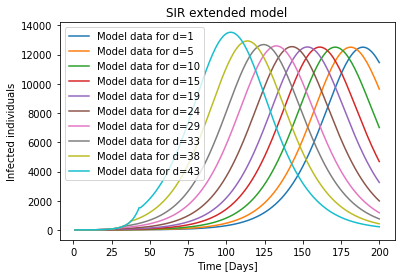

,Date,I_max,When R0 becomes <1
0,1,12511.0,[188]
1,5,12512.0,[180]
2,10,12514.0,[170]
3,15,12519.0,[160]
4,19,12526.0,[152]
5,24,12548.0,[142]
6,29,12599.0,[132]
7,33,12689.0,[123]
8,38,12938.0,[113]
9,43,13534.0,[102]


In [44]:
#we set the level of confinment to 
q=0.116689
#we sweep the value of the day
d_list=np.linspace(1,43,10)
d_list=[int(d) for d in d_list]
#total time
dt_extended=np.linspace(1,200,200)

I_max=[]
day_max=[]

for d in d_list:
    #time before
    dt_pre_conf=np.linspace(1,d,d)
    #before
    results_pre = odeint(SIR2,[S0_value_SIR ,1,0],dt_pre_conf,args = (r_value_SIR,))
    S, I, R = results_pre.T
    S_new=S[-1]
    I_new=I[-1]
    R_new=R[-1]

    #after
    SIR_results_conf=odeint(SIR_conf,[S_new,I_new,R_new],dt_extended[d:],args = (r_value_SIR,q))
    S_conf, I_conf, R_conf = SIR_results_conf.T
    #I_conf_total=list(fit_SIR_extended[0:43])
    I_conf_total=list(I)
    I_conf_total.extend(I_conf)
    I_max.append(round(max(I_conf_total)))
    day_max.append(np.where(I_conf_total==max(I_conf_total))[0])  
    
    #plot
    plt.plot(dt_extended,I_conf_total,label='Model data for d={}'.format(d))

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()
data = {'Date': list(d_list),'I_max': I_max, "When R0 becomes <1": day_max}
df = pd.DataFrame(data=data)
df    

Yo lo que saco de este ultimo caso es que el nivel de q es mas importante que la fecha... Pq fijate que aquí hemos puesto un nivel q alto de 0.1 y por lo tanto el numero maximo de ind. infectados va a ser menor que para un level de 0.0001. Pero fijate que aunque se instaura des de el primer momento vamos a llegar a un pico, pese a que el crecimiento de infectados al principio es mas lento y por ello el pico aparece mucho mas tarde. Con lo que yo saco en claro que deberiamos poner una q más alta para reducir mucho mas el numero de infectados. Que en esta caso solo vemos que se diferencian en 1000 personas, entre poner la fecha de confinamiento el dia 1 o el dia 43.

Te propongo que juegues a ponerle diferentes valores a la variable q de la ultima celda. Seguramente para poder visualizar mejor la curva deberas cambiar dt_extended=np.linspace(1,200,200), y en vez de poner 200 poner un numero mas grande si aumentas q. 